# MOND**AI**S 7th June, 2021
## traffic, a toolbox for processing and analysing air traffic data

This notebook comes with the presentation made during the MOND**AI**S webinar. It is supposed to be functional with the following version of the `traffic` library.

In [1]:
import traffic
traffic.__version__  # ensure it is at least 2.6.1

'2.6.1'

Just silence a warning which is solved in a dependency package, waiting to be published.

In [2]:
import warnings

# A DeprecationWarning should disappear with ipykernel 6.0
warnings.simplefilter("ignore", DeprecationWarning)

/opt/miniconda3/envs/py39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Outline

- [Basic usage](#Basic-usage)
- [Go-around detection](#Go-around-detection)
- [On ground airport operations](#On-ground-airport-operations)
- [Midair collision](#Closest-point-of-approach)
- [Point merge](#Point-merge)

## Basic usage

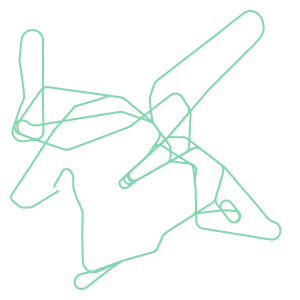

In [3]:
from traffic.data.samples import belevingsvlucht

belevingsvlucht

All Flight structures are wrapped around a Pandas DataFrame. It is always possible to fall back to the underlying dataframe for processing the data.

Chaining operations with meaningful operators from an operational point of view **does help**.

In [4]:
belevingsvlucht.data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
0,2018-05-30 15:21:38+00:00,484506,52.323970,4.739423,155,3,2240,TRA051,224
1,2018-05-30 15:21:39+00:00,484506,52.324667,4.739516,155,3,2240,TRA051,262
2,2018-05-30 15:21:40+00:00,484506,52.325363,4.739609,154,3,2240,TRA051,300
3,2018-05-30 15:21:41+00:00,484506,52.326416,4.739685,154,3,2240,TRA051,350
4,2018-05-30 15:21:42+00:00,484506,52.327136,4.739737,155,3,2240,TRA051,400
...,...,...,...,...,...,...,...,...,...
16000,2018-05-30 20:22:52+00:00,484506,52.304031,4.766015,135,58,-832,TRA051,-14
16001,2018-05-30 20:22:53+00:00,484506,52.304186,4.765894,135,58,-832,TRA051,-10
16002,2018-05-30 20:22:54+00:00,484506,52.304340,4.765772,135,58,-832,TRA051,-7
16003,2018-05-30 20:22:55+00:00,484506,52.304495,4.765651,135,58,-832,TRA051,-3


In [5]:
belevingsvlucht.duration

Timedelta('0 days 05:01:18')

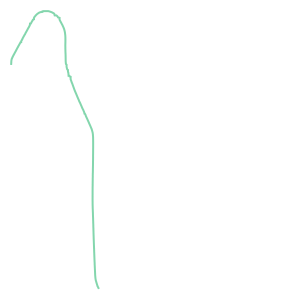

In [6]:
first10 = belevingsvlucht.first("10 minutes")
first10

- Simplification is based on the shape of the trajectory ([Douglas-Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm)).
- Resampling is provided for a given number of points, or for a given frequency.

In [7]:
first10.simplify(1e3) | first10.resample(10) | first10.resample("2T")

Plotting facilities are provided for Matplotlib, [Altair](altair-viz.github.io/) and Leaflet widgets.

In [8]:
first10.chart("altitude").interactive()

alt.Chart(...)

If you are comfortable with Altair (recommended), you can compose usual data visualisations.

In [9]:
base = first10.chart().encode(
    alt.X(
        "utchoursminutesseconds(timestamp)",
        axis=alt.Axis(title=None, format="%H:%M"),
    ),
)

alt.layer(
    base.encode(alt.Y("altitude")),
    base.encode(alt.Y("groundspeed")).mark_line(color="#f18727"),
).resolve_scale(y="independent")

alt.LayerChart(...)

Meaningful operators also help identifying special events. Some of the returned values are iterable structures (here, a single trajectory may have several take-off)

In [10]:
belevingsvlucht.takeoff_from_runway("EHAM")

An airport database is also available. More detailed information are queried from OpenStreetMap.

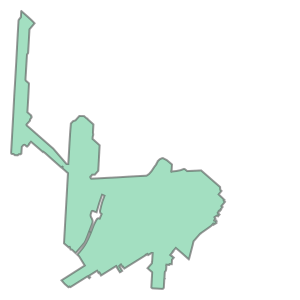

In [11]:
from traffic.data import airports

airports["EHAM"]

In [12]:
from ipywidgets import Layout

belevingsvlucht.first("10T").map_leaflet(
    zoom=12,
    highlight=dict(red="takeoff_runway_EHAM"),
    airport="EHAM",
    layout=Layout(height="600px"),
)

Map(center=[52.308601, 4.76389], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [13]:
belevingsvlucht.last("30T").map_leaflet(
    zoom=11,
    highlight=dict(red="aligned_on_EHAM"),
    airport="EHAM",
    layout=Layout(height="600px"),
)

Map(center=[52.308601, 4.76389], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

## Go-around detection

The implemented logic looks for two consecutive segments aligned on an ILS and separated by a CLIMB phase. (provided by [OpenAP](https://github.com/junzis/openap/))

In [14]:
belevingsvlucht.go_around("EHLE")

With `traffic` operators, the extraction of go-around situations becomes direct:

In [15]:
from traffic.data.datasets import landing_zurich_2019

go_arounds = (
    landing_zurich_2019.has("aligned_on_LSZH")
    .has("go_around")
    .eval(desc="", max_workers=8, cache_file="lszh_goarounds.pkl")
)

In [16]:
go_arounds

,count
flight_id,
SWR63D_6512,3088
EWG7ME_1079,3018
BAW14R_2603,2514
EDW29G_6047,2467
SWR17P_13250,2466
SWR287A_10099,2386
SWR109R_12259,2382
SWR194Z_12752,2348
AUA569_3811,2338


Find a flight with more than two attempts at landing:

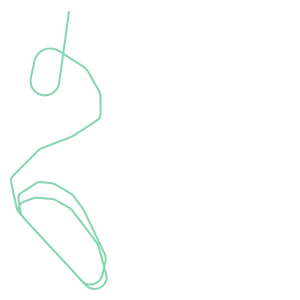

In [17]:
next(flight for flight in go_arounds if flight.go_around("LSZH").sum() > 1)

In [18]:
from ipywidgets import Layout

go_arounds["EWG7ME_1079"].map_leaflet(
    zoom=10,
    highlight=dict(
        yellow=lambda f: f.phases().query('phase == "CLIMB"').split("1T"),
        red="aligned_on_LSZH",
    ),
    airport="LSZH",
    layout=Layout(height="600px"),
)

Map(center=[47.458056, 8.548056], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

Meaningful visualisations may also be provided with operators designed for extracting features from a collection of flight into a table.

In [19]:
stats = go_arounds.summary(["stop", "icao24", "flight_id"])
stats

,stop,icao24,flight_id
0,2019-10-23 10:11:50+00:00,42438a,AFL2390_3120
1,2019-10-12 06:53:14+00:00,3950cf,AFR28NJ_957
2,2019-10-20 16:12:35+00:00,440668,AUA553_3956
3,2019-11-04 14:09:07+00:00,440549,AUA569_3811
4,2019-10-04 16:02:12+00:00,400aff,BAW14R_2603
...,...,...,...
68,2019-10-18 20:54:47+00:00,4b17e1,SWR88R_10510
69,2019-10-18 14:00:59+00:00,4b160d,SWR88U_6037
70,2019-10-15 20:06:00+00:00,4baa41,THY3KR_18552
71,2019-10-20 12:58:26+00:00,4ba8c7,THY4158_18493


In [20]:
alt.Chart(stats).encode(
    alt.X("utcyearmonthdate(stop)", title="Date"),
    alt.Color("count()", title="Number of go-arounds"),
    alt.Size("count()"),
    alt.Order("count()"),  # bigger circles on top
).mark_circle().properties(width=600).configure_legend(orient="bottom")

alt.Chart(...)

## On ground airport operations

This set of extractable features can prove useful for monitoring metrics in airport operations:

In [21]:
from traffic.data.samples import zurich_airport

from ipyleaflet import GeoData

m = (f := zurich_airport["AEE5ZH"]).map_leaflet(
    zoom=17,
    highlight=dict(
        green="slow_taxi",
        yellow="pushback_LSZH",
        red="on_parking_LSZH",
    ),
    layout=Layout(height="800px"),
)
m.add_layer(
    GeoData(
        geo_dataframe=airports["LSZH"].parking_position.data,
        style={"color": "black", "weight": 3},
        hover_style={"color": "red"},
    )
)
m

Map(center=[47.4540346098325, 8.557518889394375], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

## Closest points of approach

https://en.wikipedia.org/wiki/2021_Centennial_Airport_mid-air_collision

https://abcnews.go.com/US/wireStory/planes-collide-midair-denver-injured-77657822

![img](img/midair_collision.png)


In [22]:
from traffic.data import opensky

t = (
    opensky.history("2021-05-12", "2021-05-13", icao24=["a2cee7", "a4eabe"])
    .resample("1s")
    .eval()
)
t

  0%|          | 0/24 [00:00<?, ?it/s]

,,count
icao24,callsign,
a4eabe,N416DJ,4032
a2cee7,LYM970,3270


In [23]:
from cartes.crs import AlbersUSA

cpa = (
    t.closest_point_of_approach(
        lateral_separation=5, vertical_separation=1000, projection=AlbersUSA()
    ).aggregate()
    # clarify visualisation
    .drop(columns=["latitude_x", "longitude_x", "latitude_y", "longitude_y"])
)

cpa.merge(
    cpa.groupby(["callsign_x", "callsign_y"]).agg(dict(aggregated="min")).reset_index()
)

  0%|          | 0/1 [00:00<?, ?it/s]

Combinations:   0%|          | 0/3 [00:00<?, ?it/s]

,timestamp,altitude_x,icao24_x,callsign_x,altitude_y,icao24_y,callsign_y,lateral,vertical,aggregated
0,2021-05-12 16:23:56+00:00,6275.000000,a2cee7,LYM970,6275.000000,a4eabe,N416DJ,0.050087,0.000000,0.010017
1,2021-05-12 16:23:56+00:00,6275.000000,a4eabe,N416DJ,6275.000000,a2cee7,LYM970,0.050087,0.000000,0.010017


In [24]:
m = t.map_leaflet(zoom=12, airport="KAPA", layout=Layout(height="600px"))
m.add_layer(t.at("2021-05-12 16:23:56+00:00"))
m

Map(center=[39.57009888, -104.848999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…

## Point merge

Details on https://www.eurocontrol.int/concept/point-merge

<img style="width: 400px;" src="https://www.eurocontrol.int/sites/default/files/styles/max_960x960/public/2019-10/point-merge-diagraom-1.png?itok=fpuc8Ggk"/>

### How to detect point merge patterns, example of Dublin airport

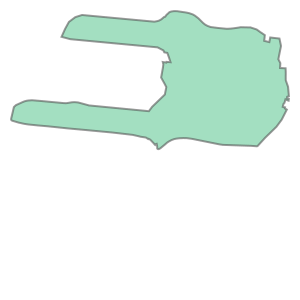

In [25]:
from traffic.data import opensky, airports

airport = airports["EIDW"]
airport

In [26]:
# Download one day of traffic

t = opensky.history(
    "2019-07-01",
    "2019-07-02",
    arrival_airport=airport.icao,
    bounds=airport.shape.buffer(3).bounds,
)
t

  0%|          | 0/24 [00:00<?, ?it/s]

count
icao24 callsign       
4ca6b1 STK27GL    5183
       STK83DU    3585
4ca74e EIN58P     3557
4ca0fe EIN477     3501
4caada STK53ED    3354
478699 SAS535     3349
4cab17 STK3343    3323
4ca8e5 RYR707E    3297
4caada STK57ED    3261
4ca9d3 RYR77VB    3195

In [27]:
# Focus on trajectories actually landing there

t_ = (
    t.assign_id()
    .resample("1s")
    .has(f"aligned_on_{airport.icao}")
    .eval(max_workers=8, desc="")
)
t_

  0%|          | 0/351 [00:00<?, ?it/s]

,count
flight_id,
STK83DU_184,3586
EIN477_050,3502
STK53ED_287,3356
SAS535_038,3350
STK57ED_288,3262
STK85DR_281,3180
RYR7085_226,3091
STK41BZ_183,3060
RYR115_065,3053


In [28]:
m_ = t_.map_leaflet()
m_

Map(center=[53.25690407487781, -5.37279319338316], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [29]:
m = (f := t["THY9EP"]).map_leaflet()
m

Map(center=[52.72824276353198, -5.194650171552025], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [30]:
import altair as alt

df = f.compute_navpoints()

alt.Chart(df.drop(columns="duration")).mark_bar().encode(
    alt.X("utchoursminutes(start)"),
    alt.X2("utchoursminutes(stop)"),
    alt.Y("navaid", sort="x"),
    alt.Color("type"),
)

alt.Chart(...)

In [31]:
from traffic.data import navaids

navaid = navaids["LAPMO"]
m_.add_layer(navaid)
m.add_layer(navaid)

Marker(location=[53.40305556, -5.94558333], options=['alt', 'draggable', 'keyboard', 'rise_offset', 'rise_on_h…

In [32]:
from traffic.data import navaids

g = (
    f.resample("1s")
    .distance(navaid)
    .bearing(navaid)
    .query("distance < 50")
    .diff(["distance", "bearing"])
)
base = g.chart()

alt.layer(
    base.encode(alt.Y("bearing")),
    base.encode(alt.Y("distance")).mark_line(color="#f18727"),
).resolve_scale(y="independent")

alt.LayerChart(...)

In [33]:
constant_distance = g.query("distance_diff.abs() < 1e-2").split("20s").max()
constant_bearing = g.after(constant_distance.start).aligned_on_navpoint(navaid).max()
constant_distance | constant_bearing

In [34]:
m = g.map_leaflet(highlight=dict(yellow=constant_distance), zoom=9)
m.add_layer(navaid)
m

Map(center=[53.21728135874737, -5.7032924289011095], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [35]:
def has_merge_point(flight) -> bool:

    # Select segments with a constant distance
    constant_distance = flight.query("distance_diff.abs() < 1e-2")
    if constant_distance is None:
        return False

    # The longest segment should exist, and be long enough
    max_ = constant_distance.split("20s").max()
    if max_ is None:
        return False
    if not max_.longer_than("1T"):
        return False

    # Finally, it must be followed with a direct to the merge point
    return flight.after(max_.start).aligned_on_navpoint(navaid).next() is not None


merge_point = (
    t.assign_id()
    .resample("1s")
    .has(f"aligned_on_{airport.icao}")
    .distance(navaid)
    .query("distance < 50")
    .diff("distance")
    .pipe(has_merge_point)
    .eval(desc="", max_workers=8)
)

  0%|          | 0/351 [00:00<?, ?it/s]

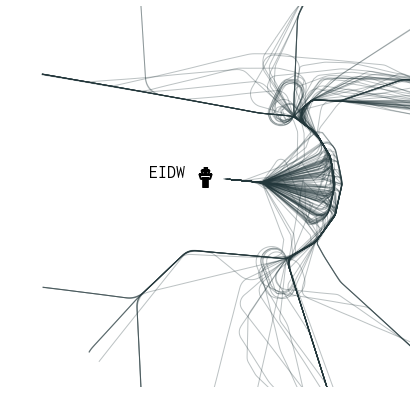

In [36]:
from cartes.crs import Mercator, PlateCarree
from traffic.drawing import countries

text_style = dict(font="Inconsolata", fontsize=18, ha="right")

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Mercator()))
    merge_point.plot(ax, color="#23373b", alpha=0.3)
    ax.set_extent((-7.4, -5.1, 52.7, 54.0))
    airport.point.plot(
        ax,
        shift=dict(x=-20, units="dots"),
        text_kw=text_style,
    )

In [37]:
%load_ext lab_black

In [38]:
t | merge_point

In [39]:
stats = t.summary(["stop", "flight_id"])
merge_stats = merge_point.summary(["stop", "flight_id"])

alt.layer(
    alt.Chart(stats).encode(alt.X("utchours(stop)"), alt.Y("count()")).mark_bar(),
    alt.Chart(merge_stats)
    .encode(
        alt.X("utchours(stop)", title="Hour in the day"),
        alt.Y("count()", title="Number of landings"),
    )
    .mark_bar(color="#f18727"),
).properties(title=f"{airport.icao}")

alt.LayerChart(...)

### Comparison with London City EGLC

In [40]:
airport = airports["EGLC"]
navaid = navaids["RAVSA"]

t = opensky.history(
    "2019-07-01",
    "2019-07-02",
    arrival_airport=airport.icao,
    bounds=airport.shape.buffer(3).bounds,
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [41]:
merge_point = (
    t.assign_id()
    .resample("1s")
    .has(f"aligned_on_{airport.icao}")
    .distance(navaid)
    .query("distance < 50")
    .bearing(navaid)
    .diff(["distance", "bearing"])
    .pipe(has_merge_point)
    .eval(desc="", max_workers=8)
)

  0%|          | 0/81 [00:00<?, ?it/s]

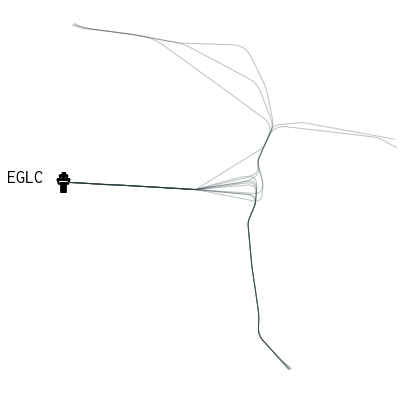

In [42]:
from cartes.crs import Mercator, PlateCarree
from traffic.drawing import countries

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Mercator()))
    merge_point.plot(ax, color="#23373b", alpha=0.3)
    airport.point.plot(
        ax,
        shift=dict(x=-20, units="dots"),
        text_kw=dict(
            font="Inconsolata",
            fontsize=18,
            ha="right",
        ),
    )

In [43]:
stats = t.summary(["stop", "flight_id"])
merge_stats = merge_point.summary(["stop", "flight_id"])

alt.layer(
    alt.Chart(stats).encode(alt.X("utchours(stop)"), alt.Y("count()")).mark_bar(),
    alt.Chart(merge_stats)
    .encode(
        alt.X("utchours(stop)", title="Hour in the day"),
        alt.Y("count()", title="Number of landings"),
    )
    .mark_bar(color="#f18727"),
).properties(title=f"{airport.icao}")

alt.LayerChart(...)

https://nats.aero/blog/2016/05/is-this-the-end-of-stack-holding/

![](https://i1.wp.com/nats.aero/blog/wp-content/uploads/2015/07/PointMergeSea2.jpg?resize=800%2C379&ssl=1)